In [18]:
import perceval as pcvl
import numpy as np
import matplotlib.pyplot as plt
import itertools
from Functions import Gaussian, Schmidt, Exponential, Lowdin, Lrz
import matplotlib.pyplot as plt
import scipy as sc

In [19]:
# Calculate the probability of an outcome for detector
def calculate_proba(n,m,measure,allstateprobs_iterator):
    r"""
    gives the probability of an output measurement
    :param n: number of spatial states
    :param m: number of internal states
    :param measure: array of how much photon we expect for each captor (array 1,n)
    :param allstateprobs_iterator: An iterator containing states and probabilities of the simulation
    :return: float probability
    """
    Proba = 0
    k = 0
    theta = np.pi/4
    c = [np.cos(theta),np.sin(theta)]
    for state, probabilitie in allstateprobs_iterator:
        ls = list(state)
        #print(state,probabilitie)
        capt = []
        for i in range(n):
            capt.append(np.sum(ls[i::n]))
        #print(capt)
        if np.all(capt==measure):
            #print(state)
            #print(probabilitie)
            Proba += probabilitie
        k+=1
    return Proba

def create_inputs(enterFunc,Coefs,Dictionnary = None): 
    #enterFunc is the distribution in space of the entry in the system ex: [1,1]
    if any(np.array(enterFunc)>1):
        raise Exception('Cannot be more than 1 photon per spatial mode')
        
    internMode = np.sum(enterFunc)
    spatialMode = len(enterFunc)
    nbPhoton = np.sum(enterFunc)
    L = spatialMode*internMode 

    Inputs = []
    for x in itertools.combinations(range(L), nbPhoton) :
        inputsTemps = [1 if i in x else 0 for i in range(L)]
        Inputs.append(np.array(inputsTemps))
    
    realInputs = []

    for i in range(len(Inputs)):
        compare = np.zeros(spatialMode)
        for ii in range(0,L,spatialMode):
            compare += Inputs[i][ii:ii+spatialMode]

        if np.all(compare == enterFunc):
            realInputs.append(Inputs[i])
    #print(realInputs)
    c = []
    Arr = np.squeeze(Coefs)
    
    for i in range(len(realInputs)):
        ArrCond = np.array(realInputs[i]).reshape(internMode,spatialMode).T
        y = np.ma.masked_array(Arr, abs(ArrCond-1))
        c.append(np.prod(y))

    k = 0

    if isinstance(Dictionnary,dict) and len(Dictionnary)!=0:
        testdict = {}

        iterkeys = itertools.permutations(Dictionnary.keys(),2)
        iterval = itertools.permutations(Dictionnary.values(),2)
        for i,j in zip(iterkeys,iterval) :
            dictkey = '|' + i[0] + ',' + i[1] + '>'
            dictval = j[0] + j[1]
            testdict[dictkey] = pcvl.BasicState(dictval)
        for i in realInputs:
            nameOfState = str(pcvl.BasicState(i))
            if k == 0:
                InputsBS = testdict[nameOfState]
                
            else:
                InputsBS = InputsBS + testdict[nameOfState]

            k += 1
        #Add the coefficient in the state vector
        k = 0
        for state,amplitude in InputsBS.items():

            InputsBS[state] = amplitude*c[k]
            k+=1
        
        return InputsBS,testdict
    else:     
        for i in realInputs:
            if k == 0 :
                InputsBS = pcvl.BasicState(i)
            else :
                InputsBS = InputsBS + pcvl.BasicState(i)
            k += 1
        #Add the coefficient in the state vector
        k = 0
        for state,amplitude in InputsBS.items():

            InputsBS[state] = amplitude*c[k]
            k+=1
        
        return InputsBS

Test CNOT

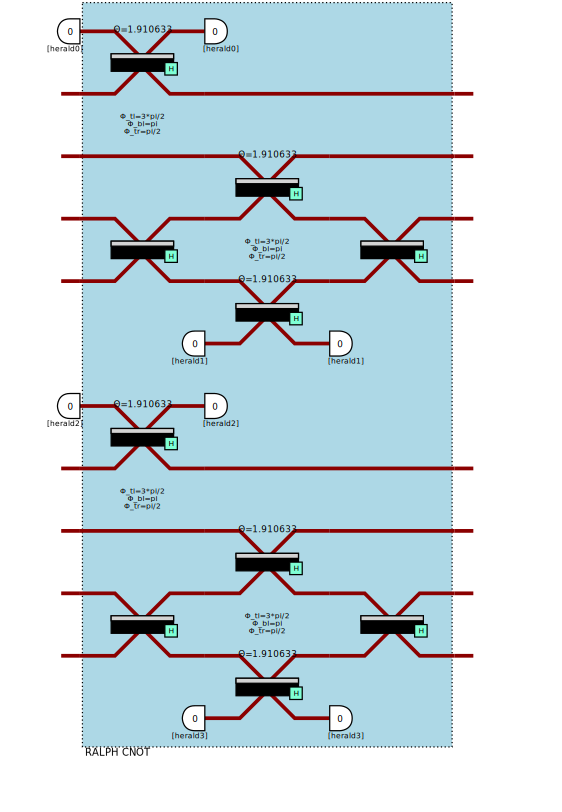

In [20]:
n = 3 #Nombre de modes spatiaux
m = 3 #Nombre de modes internes
k = 3 #Nombre de photon
cnot = pcvl.Circuit(12, name="Ralph CNOT")
cnot.add((0, 1), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((3, 4), pcvl.BS.H())
cnot.add((2, 3), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((4, 5), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
cnot.add((3, 4), pcvl.BS.H())
#first copy
cnot.add((6, 7), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((9, 10), pcvl.BS.H())
cnot.add((8, 9), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((10, 11), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
cnot.add((9, 10), pcvl.BS.H())

p = pcvl.Processor("Naive", cnot)
p.set_postprocess(lambda s: (s[1] or s[2] or s[7] or s[8]) and (s[3] or s[4] or s[9] or s[10]))
p.add_herald(0, 0)
p.add_herald(5, 0)
p.add_herald(6, 0)
p.add_herald(11, 0)

pcvl.pdisplay(p, recursive = True)




In [21]:
statesdict = {
    "0,0": [1, 0, 1, 0],
    "0,1": [1, 0, 0, 1],
    "1,0": [0, 1, 1, 0],
    "1,1": [0, 1, 0, 1]
}



In [22]:
## Getting the c vector 
env_type = 1  # 1=Gaussian, 2=exponential
N = 100  # number of x points to plot the wave functions
N_shift = 2  # total number of shifted wave functions
waves = np.zeros((N_shift, N))  # values for each wave function

sigma_wave = 0.5  # standard deviation of wave function
x = np.linspace(-16 * sigma_wave, 16 * sigma_wave, N)  # position values

shift_list=np.linspace(-8*sigma_wave,8*sigma_wave,100)
C2S=np.zeros(len(shift_list))

for k in range(len(shift_list)):
    shift=shift_list[k]
    x_shift=np.array([0,shift])
    for i in range(N_shift):
        waves[i] = Gaussian(x-x_shift[i], sigma_wave)

    new_base,coeffsS=Schmidt(waves,x)
    new_base,coeffsL = Lowdin(waves,x)
    C2S[k]=coeffsS[1,1]

0.9999999437324114


In [28]:
Probs = []
for coef in C2S:
    C = np.array([[0,0],[1,0],[0,0],[np.sqrt(1-coef ** 2),coef]])
    InputsBS = create_inputs([0,1,0,1],C)

    #print(InputsBS)


    pcvl.pdisplay(p, recursive = True)
    realOutput = {}
    for i in range(len(InputsBS)):
        miniState = InputsBS[i]
        #print(miniState,':',InputsBS[miniState])
        p.with_input(miniState)
        output = p.probs()['results']
        for ii in output.keys():
            if ii in realOutput.keys():
                realOutput[ii] = realOutput[ii] + output[ii] * abs(InputsBS[InputsBS[i]]) ** 2
            else:
                realOutput[ii] = output[ii] * abs(InputsBS[InputsBS[i]]) ** 2
    K = 0

    for i,j in zip(realOutput.keys(),realOutput.values()):
        #print(i,j)
        K += j

    #print(K)
    realOutputLs = list(realOutput.values())
    Probs.append(realOutputLs[0])



(3.354626e-4)*|0,1,0,1,0,0,0,0>+1*|0,1,0,0,0,0,0,1>
(4.619598e-4)*|0,1,0,1,0,0,0,0>+1*|0,1,0,0,0,0,0,1>
(6.320164e-4)*|0,1,0,1,0,0,0,0>+1*|0,1,0,0,0,0,0,1>
(8.590463e-4)*|0,1,0,1,0,0,0,0>+1*|0,1,0,0,0,0,0,1>
0.00116*|0,1,0,1,0,0,0,0>+1*|0,1,0,0,0,0,0,1>
0.001556*|0,1,0,1,0,0,0,0>+0.999999*|0,1,0,0,0,0,0,1>
0.002074*|0,1,0,1,0,0,0,0>+0.999998*|0,1,0,0,0,0,0,1>
0.002747*|0,1,0,1,0,0,0,0>+0.999996*|0,1,0,0,0,0,0,1>
0.003613*|0,1,0,1,0,0,0,0>+0.999993*|0,1,0,0,0,0,0,1>
0.004723*|0,1,0,1,0,0,0,0>+0.999989*|0,1,0,0,0,0,0,1>
0.006132*|0,1,0,1,0,0,0,0>+0.999981*|0,1,0,0,0,0,0,1>
0.007911*|0,1,0,1,0,0,0,0>+0.999969*|0,1,0,0,0,0,0,1>
0.010139*|0,1,0,1,0,0,0,0>+0.999949*|0,1,0,0,0,0,0,1>
0.01291*|0,1,0,1,0,0,0,0>+0.999917*|0,1,0,0,0,0,0,1>
0.016331*|0,1,0,1,0,0,0,0>+0.999867*|0,1,0,0,0,0,0,1>
0.020525*|0,1,0,1,0,0,0,0>+0.999789*|0,1,0,0,0,0,0,1>
0.025627*|0,1,0,1,0,0,0,0>+0.999672*|0,1,0,0,0,0,0,1>
0.031789*|0,1,0,1,0,0,0,0>+0.999495*|0,1,0,0,0,0,0,1>
0.039177*|0,1,0,1,0,0,0,0>+0.999232*|0,1,0,0,

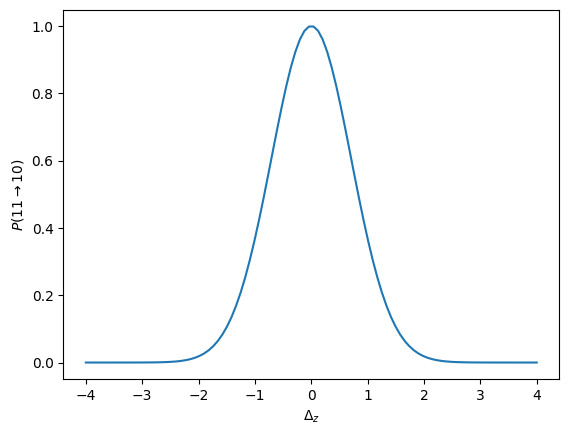

In [34]:
plt.figure()
plt.plot(shift_list,Probs)
plt.xlabel(r'$\Delta_z$')
plt.ylabel(r'$P(11 \rightarrow 10)$')
plt.show()

In [5]:
# Graph
thetaArr = np.linspace(0,np.pi/2,100)
p = pcvl.Processor("Naive", cnot)
p.set_postprocess(lambda s: (s[1] or s[2] or s[7] or s[8]) and (s[3] or s[4] or s[9] or s[10]))
p.add_herald(0, 0)
p.add_herald(5, 0)
p.add_herald(6, 0)
p.add_herald(11, 0)
""" p.add_herald(12, 0)
p.add_herald(17, 0)
p.add_herald(18, 0)
p.add_herald(23, 0) """
#  and (s[13] or s[14]) and (s[15] or s[16]) and (s[19] or s[20]) and (s[21] or s[22])
# and (s[7] or s[8]) and (s[9] or s[10])
plotArr = []
for theta in thetaArr:

    C = np.array([[0,0],[1,0],[0,0],[np.cos(theta),np.sin(theta)]])
    InputsBS = create_inputs([0,1,0,1],C)


    realOutput = {}
    for i in range(len(InputsBS)):
        miniState = InputsBS[i]
        #print(miniState,':',InputsBS[miniState])
        p.with_input(miniState)
        output = p.probs()['results']
        for ii in output.keys():
            if ii in realOutput.keys():
                realOutput[ii] = realOutput[ii] + output[ii] * InputsBS[InputsBS[i]] ** 2
            else:
                realOutput[ii] = output[ii] * InputsBS[InputsBS[i]] ** 2
    ind = list(realOutput.keys())
    
    plotArr.append(realOutput[ind[0]])
#print(plotArr)

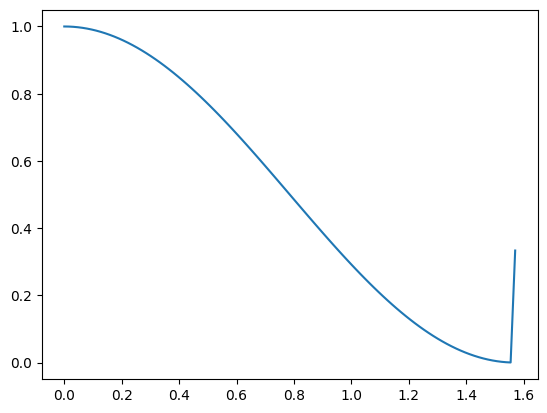

In [6]:

plt.plot(thetaArr,plotArr)